In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
mnist_train = datasets.MNIST(root='.', train=True, download=True, transform=ToTensor())
mnist_test = datasets.MNIST(root='.', train=False, download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 162130892.84it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31819199.85it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 56065854.88it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15640828.22it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_data = DataLoader(mnist_train, batch_size=4, shuffle=True, num_workers=2)

In [ ]:
test_data = DataLoader(mnist_test, batch_size=4, shuffle=True, num_workers=2)

Text(0.5, 0, '0')

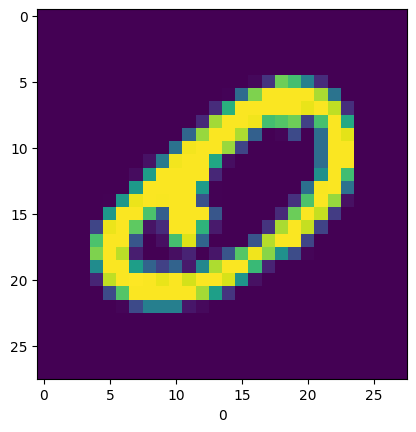

In [ ]:
import matplotlib.pyplot as plt
data = next(iter(train_data))
imgs = data[0]
labels = data[1]
img = imgs[0].permute(1, 2, 0)
plt.imshow(img)
plt.xlabel(labels[0].item())

In [ ]:
class CNN_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
    self.dense1 = nn.Linear(7*7*128, 10)
    self.act = nn.LeakyReLU(0.2)
    self.regularize = nn.Dropout(0.3)
  def forward(self, x):
    x = self.conv1(x)
    x = nn.MaxPool2d(2)(x)
    x = self.act(x)
    x = self.conv2(x)
    x = nn.MaxPool2d(2)(x)
    x = self.act(x)
    x = x.view((x.shape[0], -1))
    x = self.regularize(x)
    x = self.dense1(x)

    return nn.functional.log_softmax(x, dim=1)

def test():
  x = torch.randn((5, 1, 28, 28))
  classifier = CNN_classifier()
  output = classifier.forward(x)
  print(output)

test()

tensor([[-2.7127, -2.5308, -2.0415, -2.4499, -2.3458, -2.3542, -2.4041, -2.0022,
         -2.6164, -1.9057],
        [-2.6177, -2.4246, -1.9737, -2.5806, -2.1191, -2.5195, -2.3933, -2.1694,
         -2.4128, -2.0552],
        [-2.3859, -2.8167, -2.0499, -2.5122, -2.5175, -2.4786, -2.4926, -2.0491,
         -2.1181, -1.9517],
        [-2.3439, -2.6400, -2.1282, -2.2493, -2.0651, -2.7747, -2.4207, -2.0468,
         -2.3307, -2.2657],
        [-2.4223, -2.6168, -2.2079, -2.3438, -2.2351, -2.3514, -2.3019, -2.1392,
         -2.1849, -2.3043]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
from tqdm import tqdm
classifier = CNN_classifier().to('cuda')
optimizer = torch.optim.Adam(classifier.parameters(), lr = 1e-4)

def train(epoch):
  classifier.train()
  for batch_idx, (features, labels) in tqdm(enumerate(train_data)):
    optimizer.zero_grad()
    output = classifier(features.to('cuda'))
    loss = nn.functional.nll_loss(output, labels.to('cuda'))
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_data.dataset)))
      torch.save(classifier.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')


In [ ]:
def test():
  classifier.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_data:
      output = classifier(data.to('cuda'))
      output = output.to('cpu')
      test_loss += nn.functional.nll_loss(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_data.dataset)
  test_losses.append(test_loss)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
n_epochs = 10
log_interval = 10
test_counter = [i*len(train_data.dataset) for i in range(n_epochs+1)]

for epoch in range(n_epochs):
  train(epoch)
  test()

15000it [01:19, 188.85it/s]
15000it [01:08, 220.52it/s]
15000it [01:07, 221.72it/s]
15000it [01:07, 222.40it/s]
15000it [01:07, 222.74it/s]
15000it [01:06, 224.70it/s]
15000it [01:05, 227.82it/s]
15000it [01:07, 222.91it/s]
15000it [01:07, 220.83it/s]
15000it [01:07, 221.97it/s]


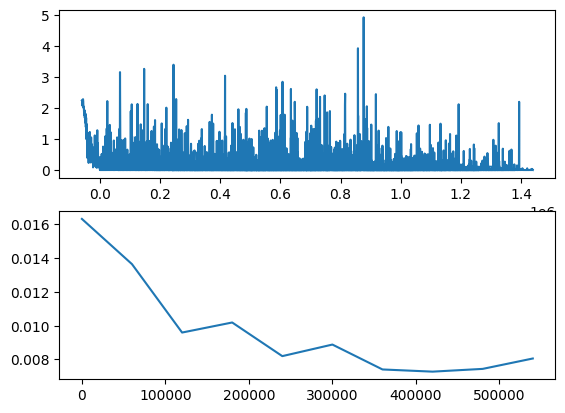

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2)
axs[0].plot(train_counter, train_losses)


axs[1].plot(test_counter[1:], test_losses)
plt.show()


Text(0.5, 0, '8')

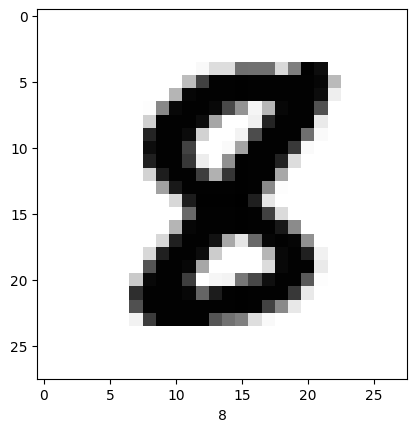

In [ ]:
test = next(iter(test_data))
img_test = test[0][0].view((1, 1, 28, 28))
label_test = test[1][0]
output = classifier(img_test.to('cuda'))
img_test = img_test[0].permute((1, 2, 0))
plt.imshow(img_test, cmap=plt.cm.binary)
plt.xlabel(torch.argmax(output).item())

In [ ]:
accuracy = []

for idx, (features, labels) in enumerate(test_data):
  output=classifier(features.to('cuda'))
  output = output.to('cpu')
  for i in range(len(output)):
    if torch.argmax(output[i]) == labels[i]:
      accuracy.append(1)
    else:
      accuracy.append(0)
print(sum(accuracy)/ len(accuracy))

0.9895


In [ ]:
import numpy as np
import pandas as pd
dataframe = pd.read_csv('test.csv', header=0).to_numpy().astype(np.float32)
dataframe = torch.from_numpy(dataframe).view(dataframe.shape[0], 1, 28, 28)
print(dataframe.shape)

torch.Size([28000, 1, 28, 28])


In [ ]:
classifier = classifier.to('cpu')
output = classifier(dataframe.to('cpu'))
output = output.to('cpu')
print(output.shape)
submission = pd.read_csv('sample_submission.csv', header=0)
for i in range(len(output)):
  submission['Label'][i] = torch.argmax(output[i])
submission.head

NameError: ignored